In [42]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import geopandas
from openai import OpenAI

with open('/content/drive/MyDrive/apikey.txt', 'r') as f:
    openai_api_key = f.read().strip()

client = OpenAI(
    api_key=openai_api_key
)

from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [4]:
file_path = '/content/drive/MyDrive/senator_twitter_May-Oct.csv'
senator_df = pd.read_csv(file_path)

senator_df.head(5)

,Unnamed: 0.1,Unnamed: 0,tweet_id,time,text,replies,retweets,likes,from_user,from_content,twitter_id,name,state,party,gender,birth,age
0,4014,37,1322145371108331520,2020-10-30 11:56:35,More jobs. More investment. More economic oppo...,40,24,143,NaN,NaN,BrianKempGA,Brian Kemp,GA,Republican,Male,NaN,57
1,4015,38,1321926867696390144,2020-10-29 21:28:20,Marty and I are excited to be back on the camp...,46,26,107,NaN,NaN,BrianKempGA,Brian Kemp,GA,Republican,Male,NaN,57
2,4016,39,1321906471244845061,2020-10-29 20:07:17,ICYMI: Gov. Kemp announces 46 people snared in...,24,30,174,NaN,NaN,BrianKempGA,Brian Kemp,GA,Republican,Male,NaN,57
3,4017,40,1321517100398268416,2020-10-28 18:20:03,I promised that Georgia would stop and dismant...,29,37,173,NaN,NaN,BrianKempGA,Brian Kemp,GA,Republican,Male,NaN,57
4,4018,41,1321478513988423680,2020-10-28 15:46:44,"Now or on November 3rd, vote for the political...",88,35,159,Kelly Loeffler,We are now less than a week away from the most...,BrianKempGA,Brian Kemp,GA,Republican,Male,NaN,57


In [38]:
# get 1 row per state + senator and their corresponding party
grouped = senator_df.groupby(['state','name'])
result = grouped.first().reset_index()
final_df = result[['state', 'name', 'party']]

# get count of tweets per state/senator
tweet_counts = grouped.size()
tweet_counts = tweet_counts.reset_index(name='tweet_count')

# merge senator info + tweet counts into one df
merged_df = pd.merge(final_df, tweet_counts, on=['state', 'name'], how='left')
merged_df.head(5)

,state,name,party,tweet_count
0,AK,Mike Dunleavy,Republican,219
1,AL,Kay Ivey,Republican,524
2,AZ,Doug Ducey,Republican,1323
3,CA,Gavin Newsom,Democratic,512
4,CO,Jared Polis,Democratic,122


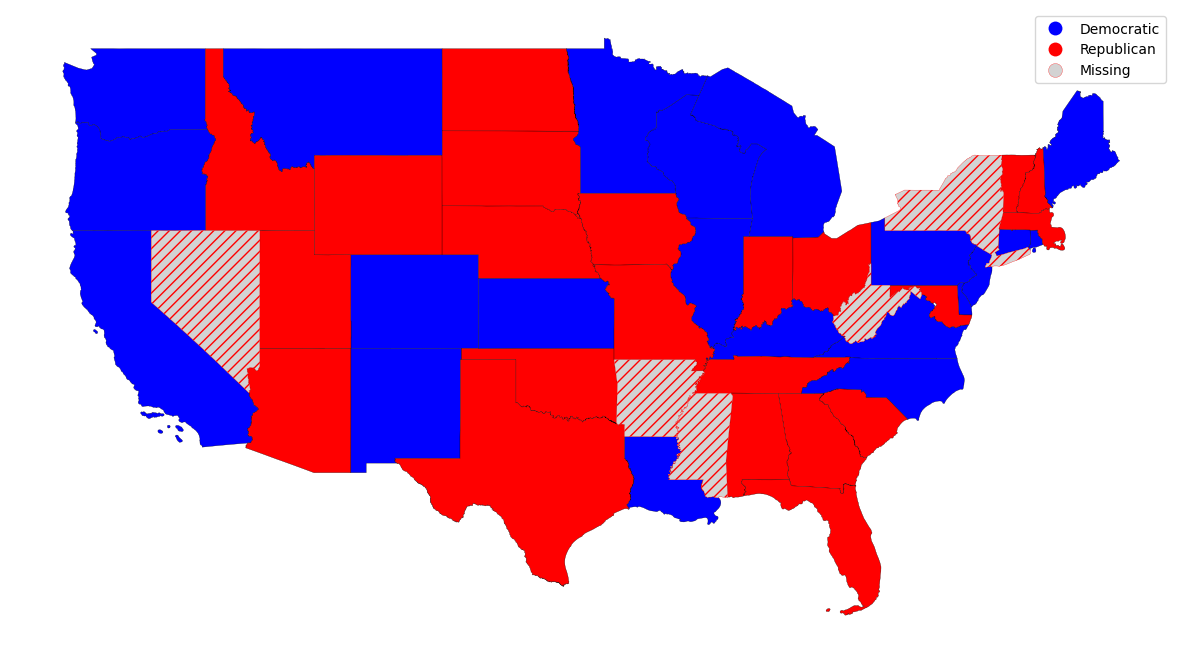

In [91]:
states = geopandas.read_file('/content/drive/MyDrive/us-state-boundaries/us-state-boundaries.shp')
states = states.to_crs(epsg=3395)

# drop non-contiguous states and plot with random color (for now)
contig_48 = states.drop([0,5,21,29,30,31,38,53])
#contig_48.plot(cmap='magma', figsize=(12,12))

# define party colors
party_colors = {'Democratic': 'blue',  'Republican': 'red'}

# merge geodata & senator tweet data into single dataframe
merged_states = contig_48.merge(merged_df, left_on='stusab', right_on='state', how='left')
merged_states['color'] = merged_states['party'].map(party_colors)

# create custom color map based on party affiliation
cmap = ListedColormap(list(party_colors.values()))

fig, ax = plt.subplots(figsize=(15,10))

merged_states.plot(
    ax=ax,
    column='party',
    cmap=cmap,
    legend=True,
    edgecolor='black',
    linewidth=0.2,
    missing_kwds={
      "color": "lightgrey",
      "edgecolor": "red",
      "hatch": "///",
      "label": "Missing",
    },
)

# Remove the axis
ax.set_axis_off()

plt.show()

In [5]:
states = [
    "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA",
    "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD",
    "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ",
    "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC",
    "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"
]

df_states = senator_df['state'].unique()

# get list of which states are not included
missing_states = [state for state in states if state not in df_states]
extra_states = [state for state in df_states if state not in states]
print(missing_states) # expecting 4 but got 5...
print(extra_states) # the extra state in our dataset

['AR', 'MS', 'NV', 'NY', 'WV']
['DC']


Scatterplot of tweet count

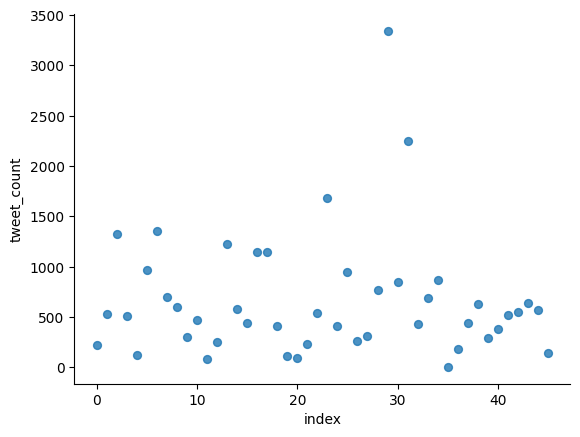

In [16]:
_df_3.plot(kind='scatter', x='index', y='tweet_count', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

Who is the mystery person from DC who snuck into our dataset?

In [ ]:
response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[{
      "role": "user",
      "content": f"Who is {unique_values['DC']}? Was he/she ever a senator of the United States?"}
])

['Muriel Bowser']


In [ ]:
print(response.choices[0].message.content)

Muriel Bowser is an American politician who has served as the Mayor of Washington, D.C., since January 2015. She is a member of the Democratic Party and was previously a member of the D.C. Council representing Ward 4. Muriel Bowser has never been a senator of the United States. Instead, she is known for her leadership in local government and her focus on issues such as affordable housing, education, and public safety in the District of Columbia.


Drop all tweets by Muriel Bowser (maybe)